# Comparing Fourier VS Wavelets VS Cosine Transform vs Fractal Compression

In [122]:
import numpy as np
from matplotlib.image import imread
import pywt
import matplotlib.pyplot as plt
import cv2
import itertools
import os
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

## Load and preprocess image

In [73]:
base_image = imread('../../data/other/lenna.png')
grey_scaled_image = np.mean(base_image, -1)

In [74]:
cv2.imwrite("grey_image.png", 255*grey_scaled_image)

True

## Define Untility function

The Peak Signal-to-Noise Ratio (PSNR) is a widely used metric for measuring the quality of reconstructed images compared to their original versions, especially in the context of image compression. PSNR is expressed in decibels (dB).

- **Higher PSNR value**: A higher PSNR indicates that the compression has preserved more of the original image's details, leading to a higher quality reconstructed image. In general, a higher PSNR is seen as better, indicating less distortion.

- **Lower PSNR value**: A lower PSNR suggests more distortion and a greater difference between the original and compressed images, implying lower quality of the reconstructed image.

PSNR is calculated using the following formula:

$$ \text{PSNR} = 10 \cdot \log_{10} \left( \frac{\text{MAX}_I^2}{\text{MSE}} \right) $$

where:
- $ \text{MAX}_I $ is the maximum possible pixel value of the image. For example, for an 8-bit grayscale image, the maximum value is 255.
- $ \text{MSE} $  is the mean squared error between the original and compressed image.

While PSNR provides a mathematical measure of image reconstruction quality, it doesn't always perfectly match human perception of visual quality. In other words, an image with a higher PSNR might not always look better to human observers compared to one with a lower PSNR. This is due to the PSNR metric's simplicity and its focus on pixel-level differences rather than taking into account how humans perceive visual information.

Here's a rough guide to PSNR values:
- **Below 30 dB**: The quality might be generally unacceptable, showing significant differences between the original and compressed images.
- **Between 30 dB to 40 dB**: This range is often considered as fair to good, with some noticeable differences between the original and compressed images.
- **Above 40 dB**: Images are generally perceived as being close to the original, with very minor differences. Quality is considered very good to excellent.

In [75]:
# Better not to use our own methods
@DeprecationWarning
def PSNR(original_image:np.array, compressed_image:np.array):
    mse = np.mean((original_image - compressed_image) ** 2)
    if mse == 0:  # This means no difference between original and compressed images.
        return float('inf')  
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse)) 
    return psnr

In [76]:
# Better not to use our own methods
@DeprecationWarning
def SSIM(img1, img2, C1=6.5025, C2=58.5225):
    """
    Compute the SSIM between two images.
    
    :param img1: First input image.
    :param img2: Second input image.
    :param C1: Stability constant C1.
    :param C2: Stability constant C2.
    :return: SSIM index.
    """
    # Ensure the input images have the same dimensions
    assert img1.shape == img2.shape, "Input images must have the same dimensions"
    
    # Calculate means
    mu1 = np.mean(img1)
    mu2 = np.mean(img2)
    
    # Calculate variances and covariance
    sigma1_sq = np.var(img1)
    sigma2_sq = np.var(img2)
    sigma12 = np.cov(img1.ravel(), img2.ravel())[0, 1]
    
    # Calculate SSIM
    ssim_numerator = (2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)
    ssim_denominator = (mu1**2 + mu2**2 + C1) * (sigma1_sq + sigma2_sq + C2)
    ssim = ssim_numerator / ssim_denominator
    
    return ssim

In [77]:
@DeprecationWarning
def compress_image_dwt(original_image: np.array, wavelet, level, keep):
    coeffs = pywt.wavedec2(data=original_image, wavelet=wavelet, level=level + 1)  # Adjusting level for 1-based indexing
    coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    Csoft = np.sort(np.abs(coeff_arr.reshape(-1)))

    thresh = Csoft[int(np.floor((1 - keep) * len(Csoft)))]
    
    ind = np.abs(coeff_arr) > thresh

    Cfilt = coeff_arr * ind
    coeffs_filt = pywt.array_to_coeffs(Cfilt, coeff_slices, output_format='wavedec2')

    reconstructed_image = pywt.waverec2(coeffs_filt, wavelet=wavelet)
    # this was added just in case we need to plot it
    # I am not joking, I wasn't just bored
    # reconstructed_image_uint8 = np.clip(reconstructed_image, 0, 1) * 255  # Adjusting the range to [0,255] and clipping
    # reconstructed_image_uint8 = reconstructed_image_uint8.astype('uint8')
    return reconstructed_image

In [104]:
def compress_image_with_pywt(image_path, wavelet='haar', level=2):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    coeffs = pywt.wavedec2(img, wavelet, mode="antireflect",  level=level)  

    coeffs_thresh = []
    coeffs_thresh.append(coeffs[0])
    for detail_coeffs in coeffs[1:]: 
        h, v, d = detail_coeffs
        h_thresh = pywt.threshold(h, np.inf, mode='hard')
        v_thresh = pywt.threshold(v, np.inf, mode='hard')
        d_thresh = pywt.threshold(d, np.inf, mode='hard')
        coeffs_thresh.append((h_thresh, v_thresh, d_thresh))
    
    reconstructed_img = pywt.waverec2(coeffs_thresh, wavelet)
    cv2.imwrite('compressed_reconstructed_image.jpeg', reconstructed_img)
    normalized_image = reconstructed_img/255
    return normalized_image, 4**level


## Making experiments with compressing images with wavelet transform

### Defining hyperparams

In [119]:
maximum_level = 6
# using most common wavelets 
wavelets = ["haar","sym10" ,"sym2", "bior4.4", "db10", "coif10", "db20", "rbio3.5"]
keep = 0.99  # we will keep 70% of data

# data for plotting
data = [] 

### Plotting setting

In [120]:
fig, axs = plt.subplots(len(wavelets), maximum_level, figsize=(20, 20))
psnr_values = {wavelet: [] for wavelet in wavelets}
compressions = {wavelet: [] for wavelet in wavelets}
ssims = {wavelet: [] for wavelet in wavelets}

plt.ioff()
# remove ticks from plot
for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=1)
    ax.tick_params(axis='both', which='minor', labelsize=1)  

/Users/WorkAndStudy/.pyenv/versions/3.11.1/envs/data-analysis/lib/python3.11/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/Users/WorkAndStudy/.pyenv/versions/3.11.1/envs/data-analysis/lib/python3.11/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


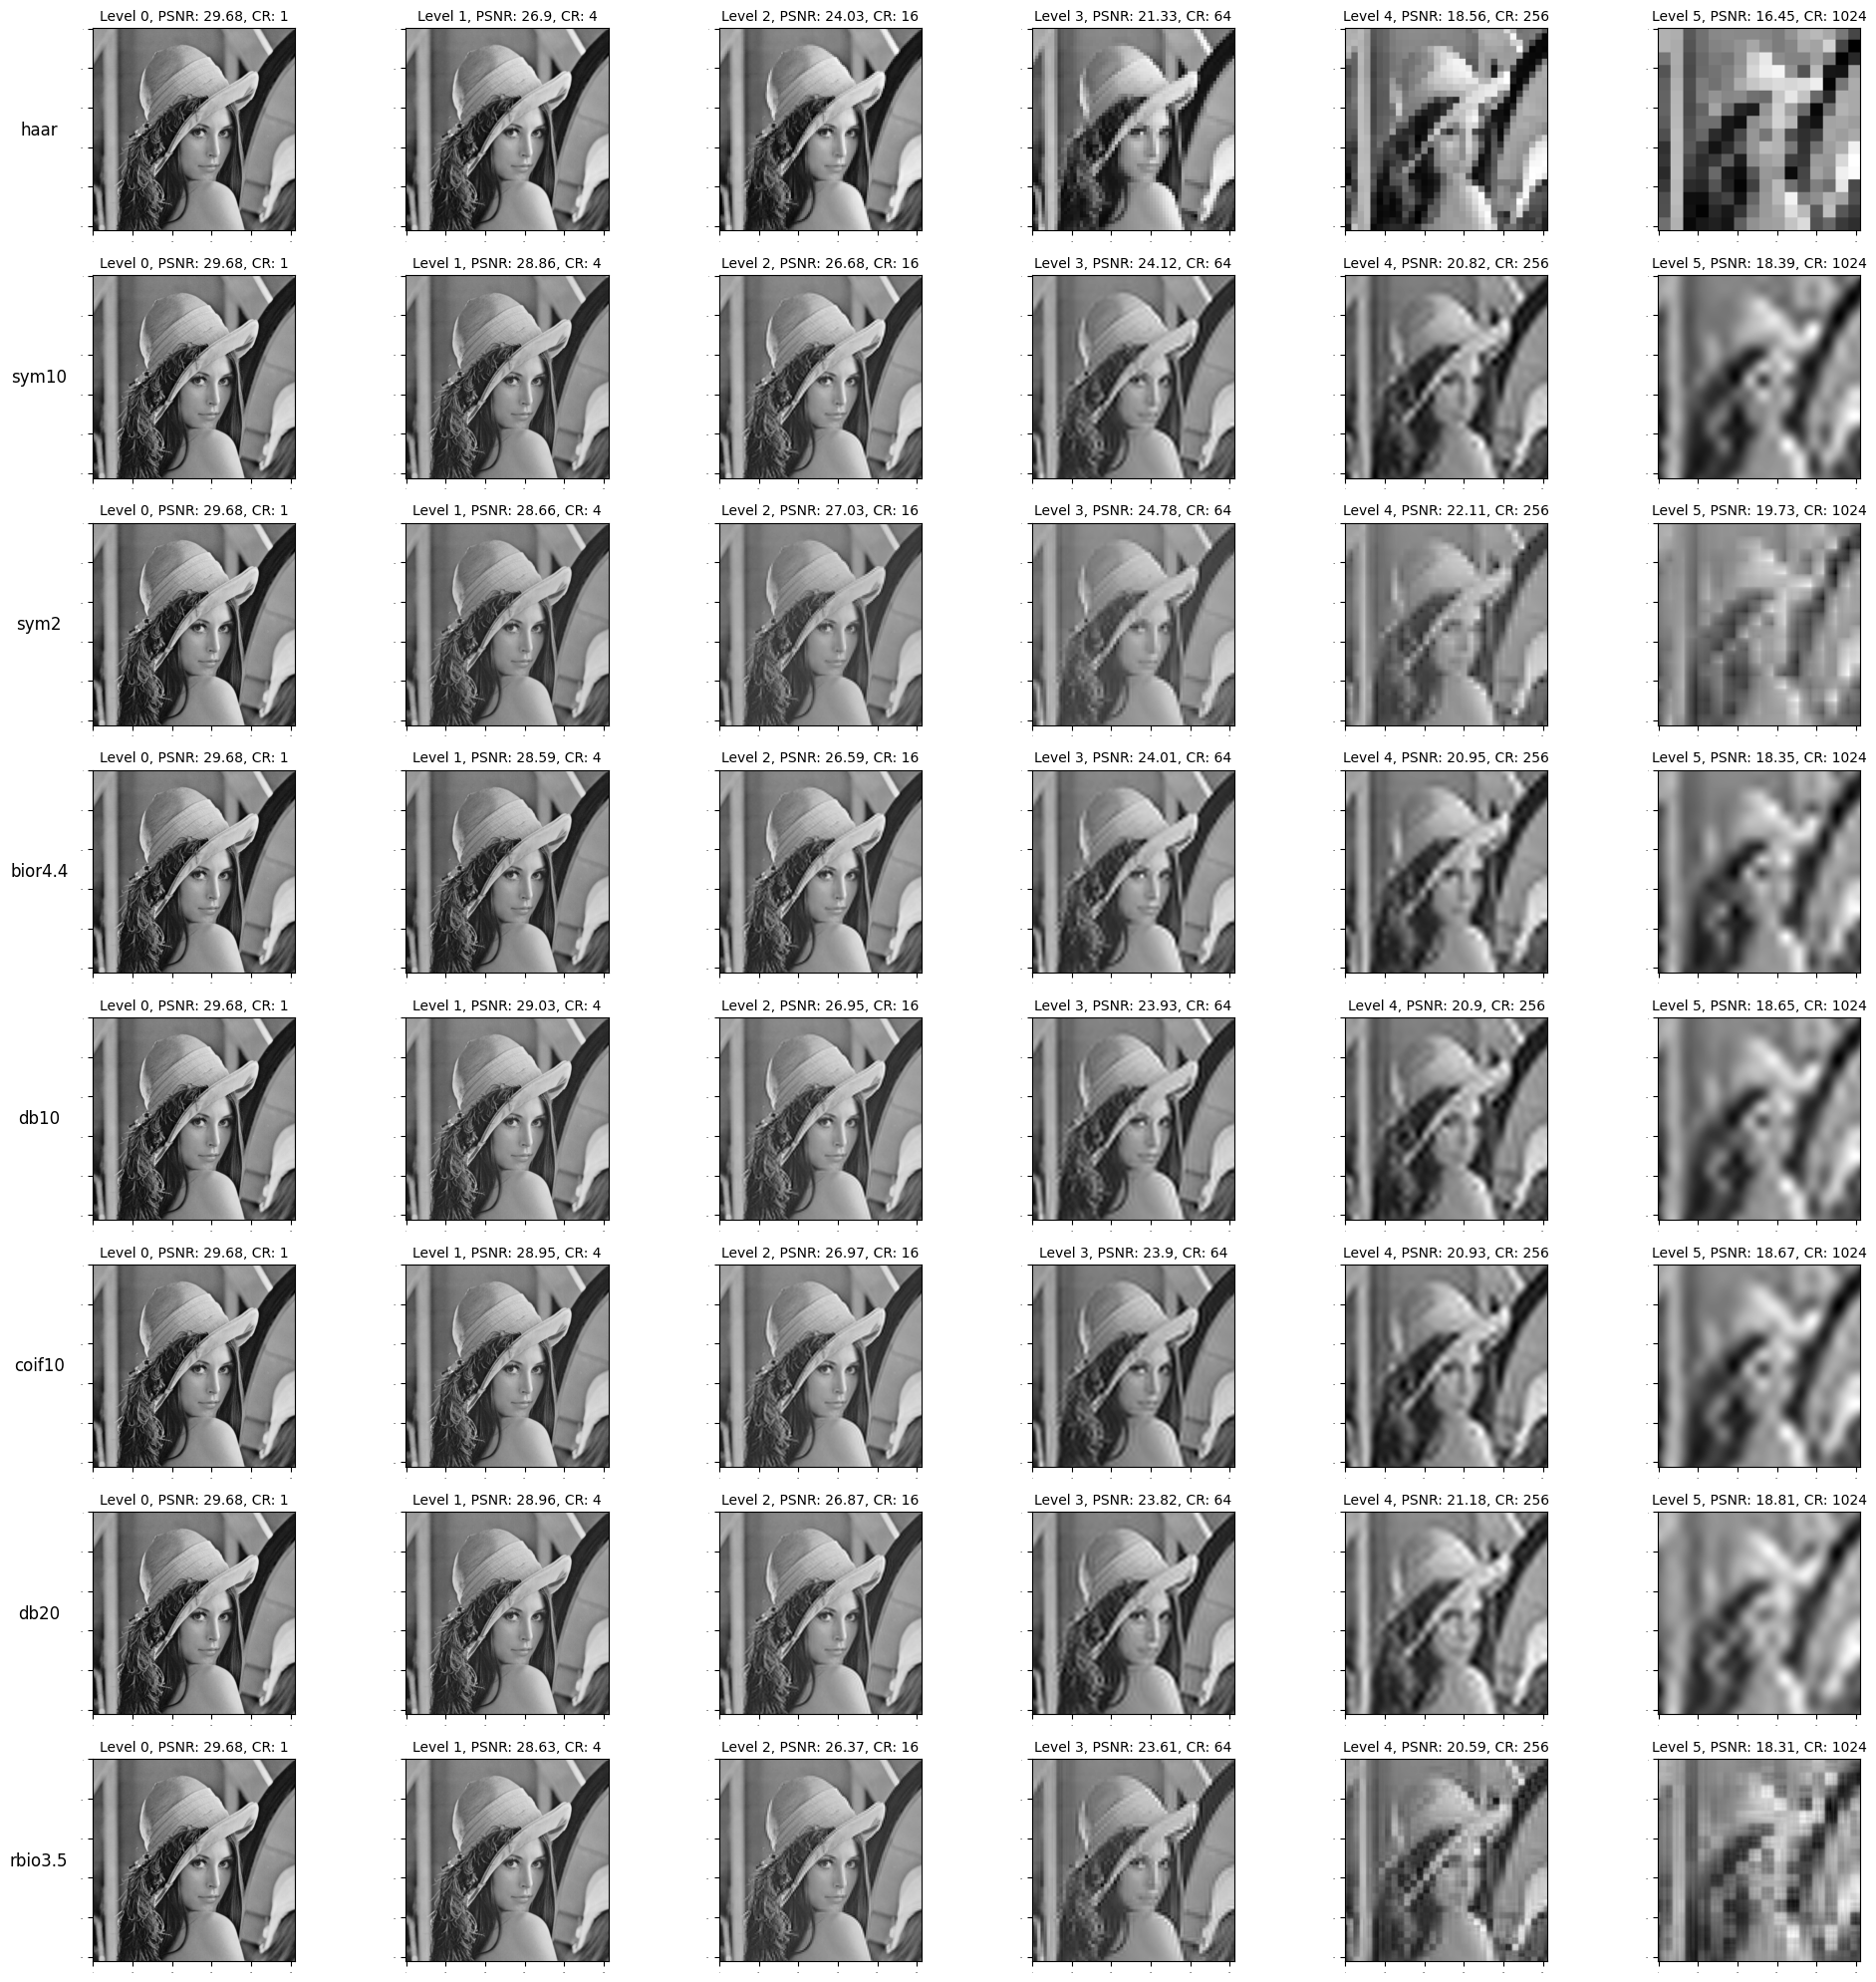

In [123]:
base_image_size = os.stat('grey_image.png').st_size

for level in range(maximum_level):
    data.append([])
    for wave_index, wave in enumerate(wavelets):
        reconstructed_image, compression_rate = compress_image_with_pywt('../../data/other/lenna.png', wavelet=wave, level=level)
        

        psnr_metric = psnr(grey_scaled_image, reconstructed_image, data_range=grey_scaled_image.max() - reconstructed_image.min())
        ssim_metric = ssim(grey_scaled_image, reconstructed_image, data_range=grey_scaled_image.max() - reconstructed_image.min())
        axs[wave_index, level].imshow(reconstructed_image, cmap='gray')
        axs[wave_index, level].set_title(f'Level {level}, PSNR: {np.round(psnr_metric, 2)}, CR: {compression_rate}', fontsize=10)

        if level == 0:  
            axs[wave_index, level].set_ylabel(wave, rotation=0, size='large', labelpad=30, verticalalignment='center')

        psnr_values[wave].append(psnr_metric)
        compressions[wave].append(compression_rate)
        ssims[wave].append(ssim_metric)

        # compression rate for table
        data[level].append(compression_rate)

plt.tight_layout()
plt.show()

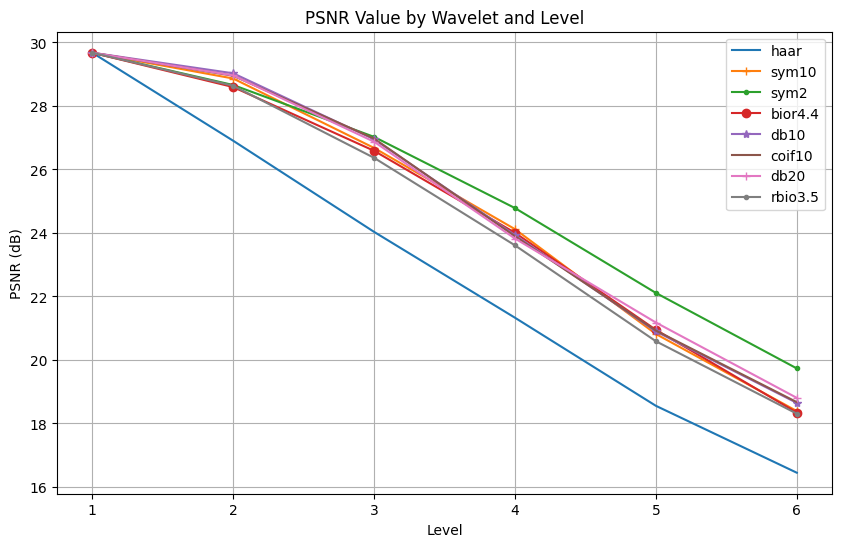

In [124]:
plt.figure(figsize=(10, 6))
marker = itertools.cycle((',', '+', '.', 'o', '*')) 

for wavelet in wavelets:
    plt.plot(range(1, maximum_level + 1), psnr_values[wavelet], label=wavelet, marker=next(marker))

plt.xlabel('Level')
plt.ylabel('PSNR (dB)')
plt.title('PSNR Value by Wavelet and Level')
plt.legend()
plt.grid(True)
plt.show()

### Compression Rate

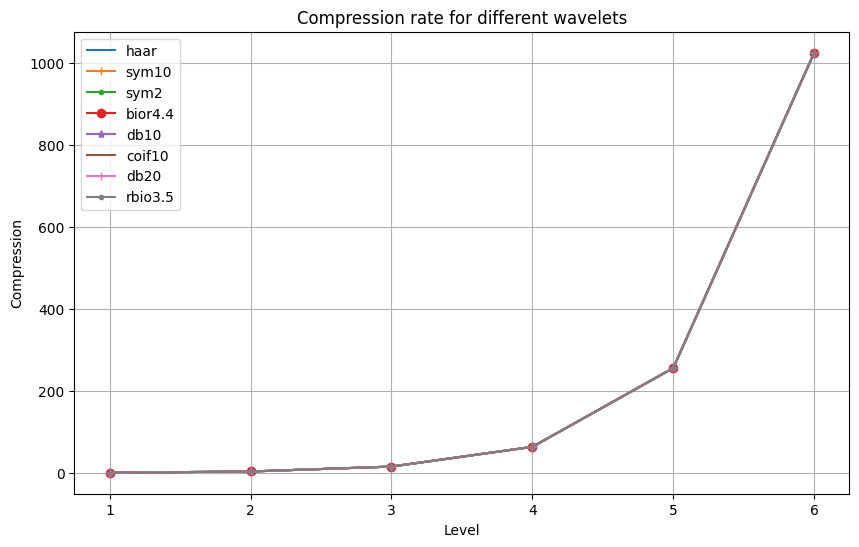

In [114]:
plt.figure(figsize=(10, 6))
marker = itertools.cycle((',', '+', '.', 'o', '*')) 

for wavelet in wavelets:
    plt.plot(range(1, maximum_level + 1), compressions[wavelet], label=wavelet, marker=next(marker))

plt.xlabel('Level')
plt.ylabel('Compression')
plt.title('Compression rate for different wavelets')
plt.legend()
plt.grid(True)
plt.show()

# ssim

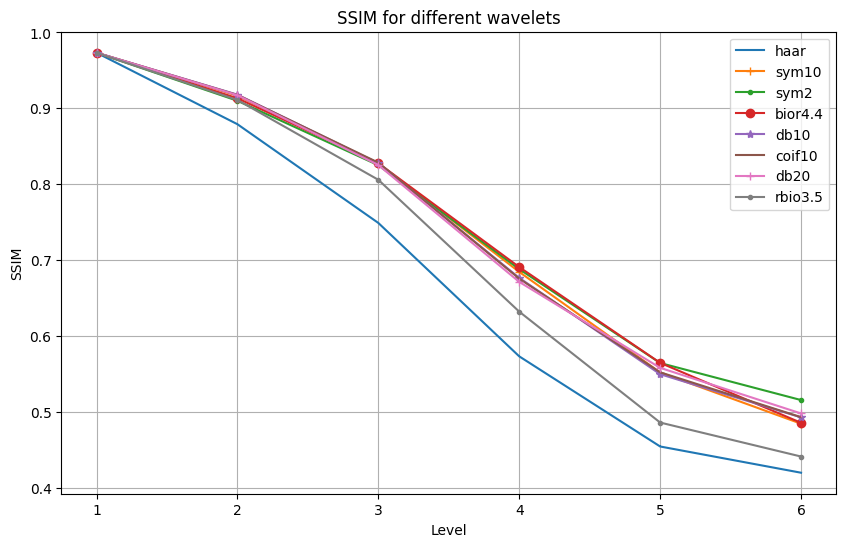

In [115]:
plt.figure(figsize=(10, 6))
marker = itertools.cycle((',', '+', '.', 'o', '*')) 

for wavelet in wavelets:
    plt.plot(range(1, maximum_level + 1), ssims[wavelet], label=wavelet, marker=next(marker))

plt.xlabel('Level')
plt.ylabel('SSIM')
plt.title('SSIM for different wavelets')
plt.legend()
plt.grid(True)
plt.show()

## Discrete Cosine Transform

DCT is based on decomposition of image using this blocks 

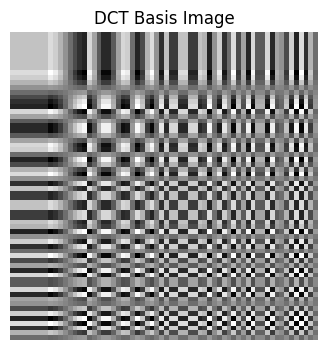

In [21]:
# DCT matrix
N=8 # matrix shape: 8*8
DCT=np.zeros((N,N))
for m in range(N):
    for n in range(N):
        if m==0:
            DCT[m][n]=np.sqrt(1/N)
        else:
            DCT[m][n]=np.sqrt(2/N)*np.cos((2*n+1)*np.pi*m/(2*N))

# DCT basis image
basis=np.zeros((N*N,N*N))
for m in range(N):
    for n in range(N):
        pos_m=m*N
        pos_n=n*N
        DCT_v=DCT[m,:].reshape(-1,1)
        DCT_T_h=DCT.T[:,n].reshape(-1,N)
        basis[pos_m:pos_m+N,pos_n:pos_n+N]=np.matmul(DCT_v,DCT_T_h)

# Center values
basis+=np.absolute(np.amin(basis))
scale=np.around(1/np.amax(basis),decimals=3)
for m in range(basis.shape[0]):
    for n in range(basis.shape[1]):
        basis[m][n]=np.around(basis[m][n]*scale,decimals=3)

# Show basis image
plt.figure(figsize=(4,4))
plt.gray()
plt.axis('off')
plt.title('DCT Basis Image')
plt.imshow(basis,vmin=0)
plt.show()

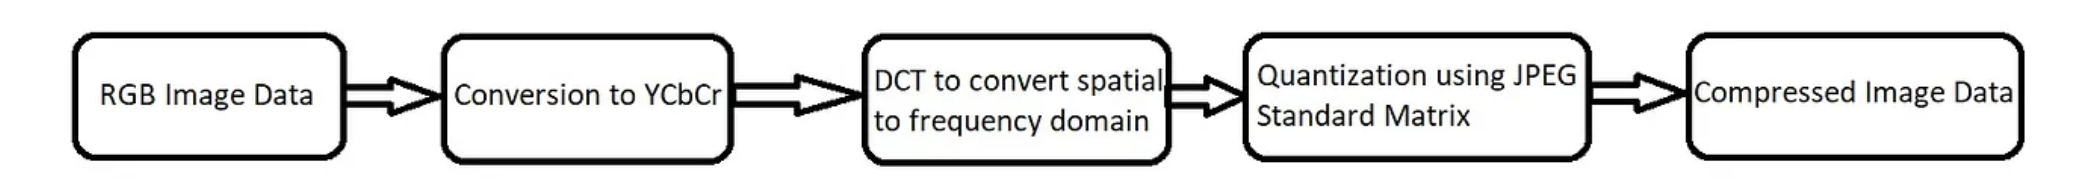

In [22]:
import numpy as np
from scipy.fftpack import dct, idct

def dct_2d(image):
    return dct(dct(image.T,type=2, norm='ortho').T, norm='ortho')

def idct_2d(coefficients):
    return idct(idct(coefficients.T, norm='ortho').T, norm='ortho')

dct_coeffs = dct_2d(grey_scaled_image)
reconstructed_image = idct_2d(dct_coeffs)
threshold = np.quantile(np.abs(dct_coeffs), 0.8)
dct_coeffs[np.abs(dct_coeffs) < threshold] = 0

cv2.imwrite('compressed_image_dct_1.jpg', dct_coeffs)
readed_coefs = cv2.imread('compressed_image_dct_1.jpg')
compressed_image = idct_2d(readed_coefs)

In [23]:
block = grey_scaled_image[0:8, 0:8]

dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')

Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
              [12, 12, 14, 19, 26, 58, 60, 55],
              [14, 13, 16, 24, 40, 57, 69, 56],
              [14, 17, 22, 29, 51, 87, 80, 62],
              [18, 22, 37, 56, 68, 109, 103, 77],
              [24, 35, 55, 64, 81, 104, 113, 92],
              [49, 64, 78, 87, 103, 121, 120, 101],
              [72, 92, 95, 98, 112, 100, 103, 99]])

quantized = np.round(dct_block / Q)
reconstructed_block = idct(idct(quantized * Q, axis=0 , norm='ortho'), axis=1, norm='ortho')

print("Original Block:\n", block)
print("Reconstructed Block:\n", reconstructed_block)

Original Block:
 [[0.6379085  0.6379085  0.64444447 0.63660127 0.63267976 0.61568624
  0.6392157  0.63398695]
 [0.6379085  0.6379085  0.64444447 0.63660127 0.63267976 0.61568624
  0.6392157  0.63398695]
 [0.6379085  0.6379085  0.64444447 0.63660127 0.63267976 0.61568624
  0.6392157  0.63398695]
 [0.6379085  0.6379085  0.64444447 0.63660127 0.63267976 0.61568624
  0.6392157  0.63398695]
 [0.6379085  0.6379085  0.64444447 0.63660127 0.63267976 0.61568624
  0.6392157  0.63398695]
 [0.6405229  0.6405229  0.6156863  0.6052288  0.6300654  0.62222224
  0.6248366  0.62222224]
 [0.6287582  0.6287582  0.6300654  0.6169935  0.63267976 0.6248366
  0.62352943 0.6039216 ]
 [0.62352943 0.62352943 0.60261434 0.61045754 0.6248366  0.61960787
  0.6104575  0.6078431 ]]
Reconstructed Block:
 [[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


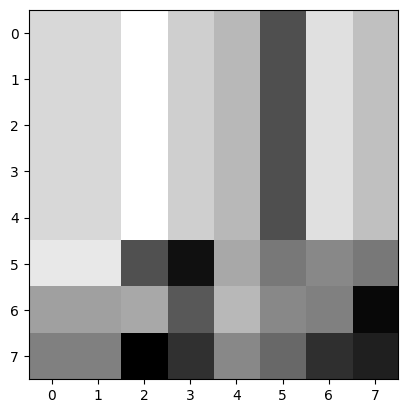

In [24]:
plt.imshow(block)
plt.show()

Defining hyperparameters

There are 4 types for cosine Transform

In [51]:
types = [1, 2, 3, 4]
compressions = []
psnrs = []

In [52]:
def quantize_image(dct_img, Q):
    height, width = dct_img.shape
    quantized_img = np.zeros_like(dct_img)  # Initialize the quantized image array
    
    for i in range(0, height, 8):
        for j in range(0, width, 8):
            # Extract the 8x8 block from the image
            block = dct_img[i:i+8, j:j+8]
            # Apply the quantization matrix
            quantized_block = np.round(block / Q)
            # Place the quantized block back into the quantized image array
            quantized_img[i:i+8, j:j+8] = quantized_block
            
    return quantized_img

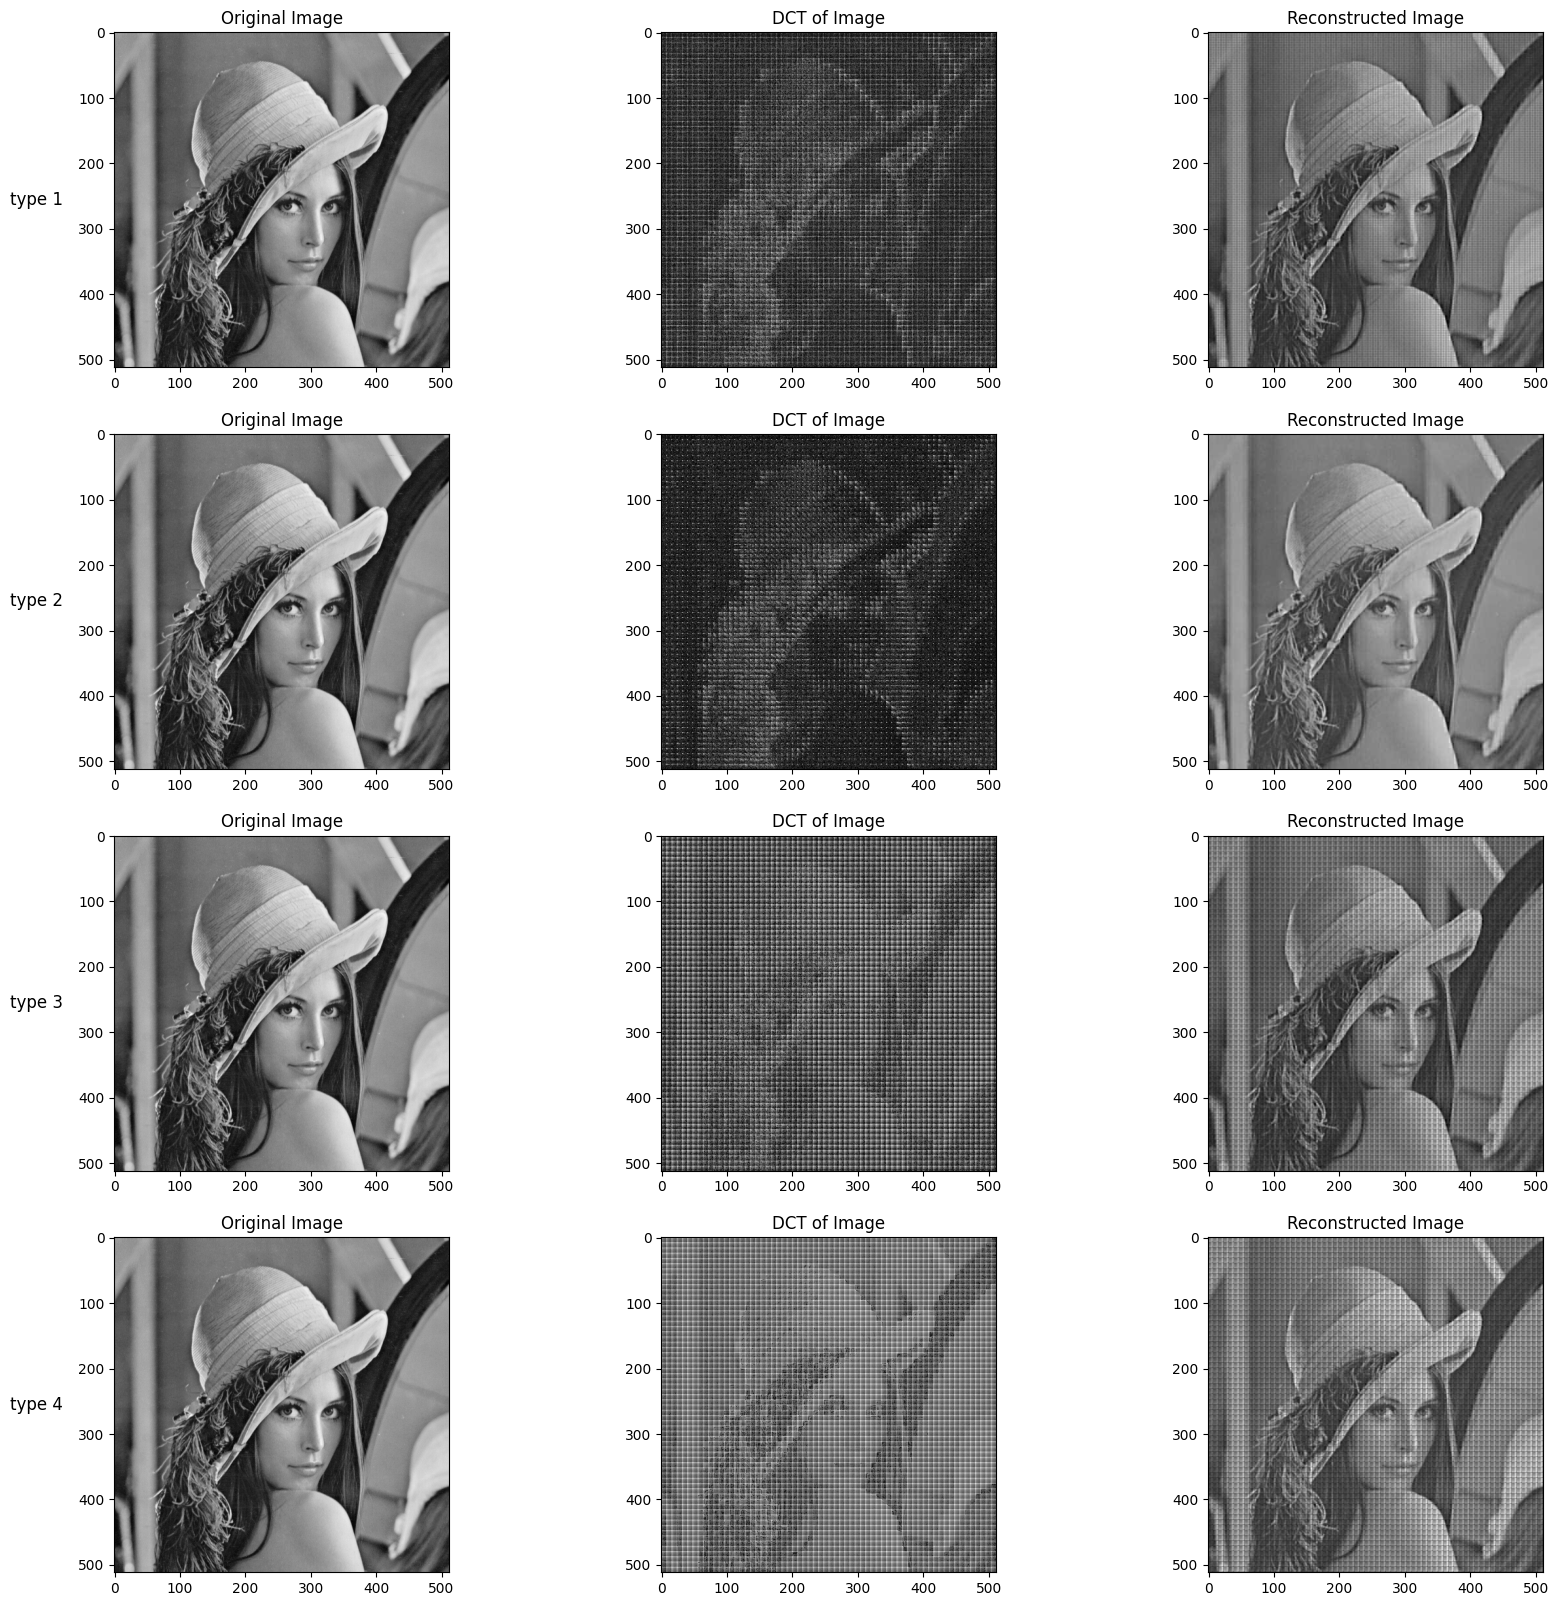

In [57]:
def apply_dct(image, type=2):
    """Apply DCT to each 8x8 block of the image."""
    height, width = image.shape
    compressed = np.zeros((height, width), np.float32)
    for i in range(0, height, 8):
        for j in range(0, width, 8):
            block = image[i:i+8, j:j+8]
            dct_block = dct(dct(block.T, type=type, norm='ortho').T, type=type, norm='ortho')
            compressed[i:i+8, j:j+8] = dct_block
    return compressed

def apply_idct(compressed, type=2):
    """Apply IDCT to decompress the image."""
    height, width = compressed.shape
    decompressed = np.zeros((height, width), np.float32)
    for i in range(0, height, 8):
        for j in range(0, width, 8):
            block = compressed[i:i+8, j:j+8]
            idct_block = idct(idct(block.T, type=type, norm='ortho').T, type=type, norm='ortho')
            decompressed[i:i+8, j:j+8] = idct_block
    return decompressed


fig, axs = plt.subplots(len(types), 3, figsize=(20, 20))

img = cv2.imread('grey_image.png', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (512, 512))

# Quantization matrix for JPEG
Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
              [12, 12, 14, 19, 26, 58, 60, 55],
              [14, 13, 16, 24, 40, 57, 69, 56],
              [14, 17, 22, 29, 51, 87, 80, 62],
              [18, 22, 37, 56, 68, 109, 103, 77],
              [24, 35, 55, 64, 81, 104, 113, 92],
              [49, 64, 78, 87, 103, 121, 120, 101],
              [72, 92, 95, 98, 112, 100, 103, 99]])


for i, type in enumerate(types):

    dct_img = apply_dct(img,type=type)
    quantized_dct = quantize_image(dct_img, Q)
    idct_img = apply_idct(quantized_dct,type=type)

    axs[i, 0].set_ylabel("type "+ str(type), rotation=0, size='large', labelpad=30, verticalalignment='center')

    axs[i, 0].imshow(img, cmap='gray')
    axs[i, 0].set_title('Original Image')

    axs[i, 1].imshow(np.log(abs(dct_img) + 1), cmap='gray')
    axs[i, 1].set_title('DCT of Image')

    axs[i, 2].imshow(idct_img, cmap='gray')
    axs[i, 2].set_title('Reconstructed Image')
    psnr = PSNR(img, idct_img)
    cv2.imwrite("compressed_dct.jpeg",255*idct_img)
    compressed_dct_size = os.stat('compressed_dct.jpeg').st_size

    compression = compressed_dct_size / base_image_size
    compressions.append(compression)
    psnrs.append(psnr)
    
plt.show()


### PSNR Calculations

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


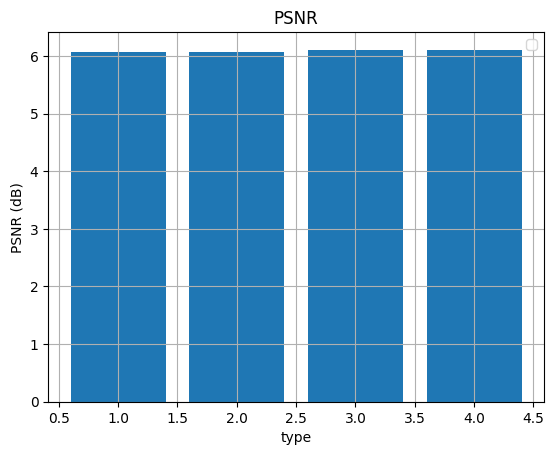

In [54]:
plt.bar(types, psnrs)

plt.xlabel('type')
plt.ylabel('PSNR (dB)')
plt.title('PSNR')
plt.legend()
plt.grid(True)
plt.show()

## Compression Ratio

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


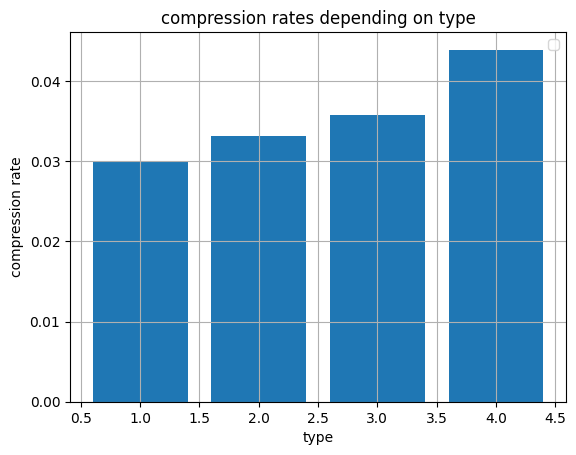

In [55]:
plt.bar(types, compressions)

plt.xlabel('type')
plt.ylabel('compression rate')
plt.title('compression rates depending on type')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
compressions

[0.029944024781261888,
 0.0330899890706423,
 0.03571061959193039,
 0.043886503752815366]

## Fourier Transfrom 

In [20]:
keeps = np.arange(0.01, 0.99, 0.02)

In [21]:
compressions = []
fourier_psnr = []
base_image_size = os.stat('grey_image.png').st_size

In [22]:
Bt = np.fft.fft2(grey_scaled_image)
Btsort = np.sort(np.abs(Bt).reshape(-1))

for i, keep in enumerate(keeps, start=1):
    thresh = Btsort[int(np.floor((1-keep) * len(Btsort)))]
    ind = np.abs(Bt) > thresh  
    Filtered_coefficients = Bt * ind  
    B_rec = np.fft.ifft2(Filtered_coefficients).real  
    
    cv2.imwrite(f"compressed.png", 255*B_rec)
    compressed_image_size = os.stat(f"compressed.png").st_size

    comression = compressed_image_size / base_image_size
    compressions.append(comression)
    
    psnr = PSNR(base_image_size, compressed_image_size)
    fourier_psnr.append(psnr)
    # plt.imshow(np.log(np.abs(Filtered_coefficients) + 1), cmap='gray')
    # plt.axis('off')
    # plt.figure()
    
    # plt.imshow(B_rec, cmap='gray')
    # plt.title(f"Reconstructed image with {keep * 100}% of coefficients")
    # plt.axis('off')
    # plt.show()

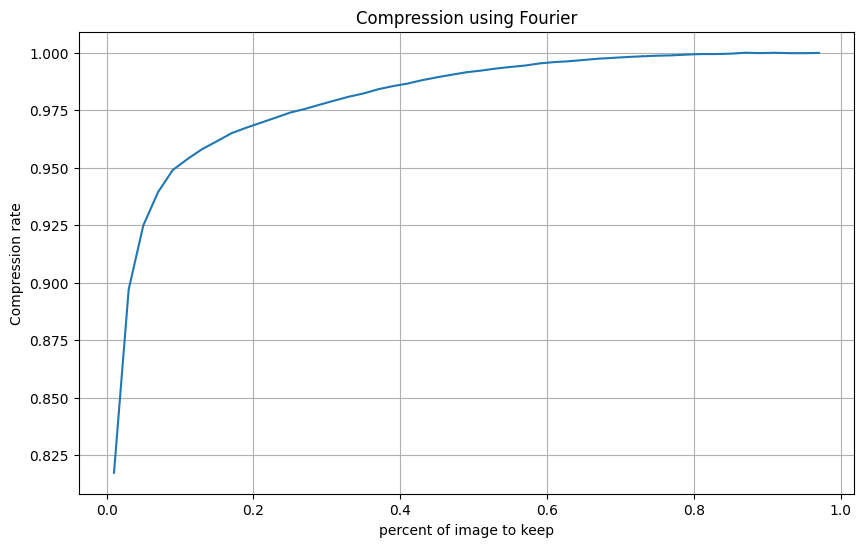

In [23]:
plt.figure(figsize=(10, 6))
marker = itertools.cycle((',', '+', '.', 'o', '*')) 

plt.plot(keeps, compressions, label=keep, marker=next(marker))

plt.xlabel('percent of image to keep')
plt.ylabel('Compression rate')
plt.title('Compression using Fourier')
plt.grid(True)
plt.show()

# PSNR 

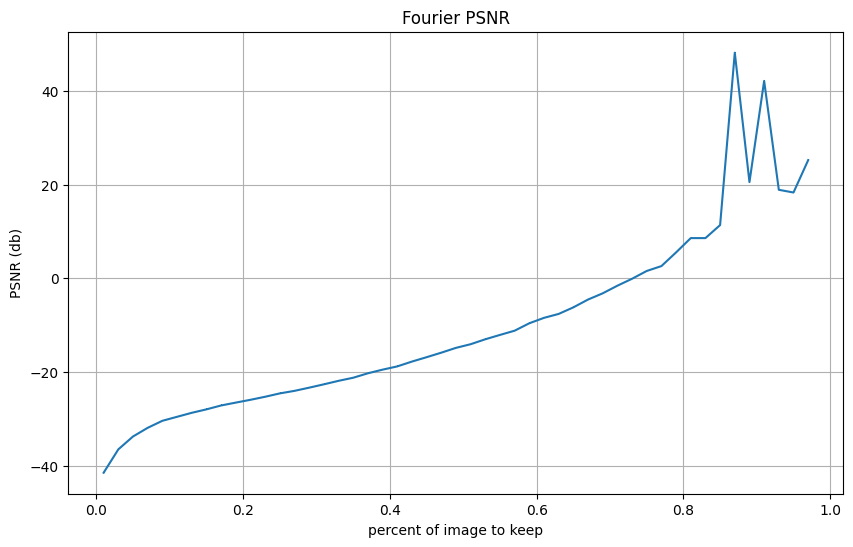

In [24]:
plt.figure(figsize=(10, 6))
marker = itertools.cycle((',', '+', '.', 'o', '*')) 

plt.plot(keeps, fourier_psnr, label=keep, marker=next(marker))

plt.xlabel('percent of image to keep')
plt.ylabel('PSNR (db)')
plt.title('Fourier PSNR')
plt.grid(True)
plt.show()

- Test on different Images, if it depents on picture
- Conclusions: 
  - Give the brief introduction to algorithms that can be used
  - What can we conclude from plots 
  - Brief repetitions of paper 
  - 